In [1]:
# import required library
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import warnings
import optuna
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from utils import scale_data, inverse_transform, scatterplot, lineplot
from sklearn.feature_selection import SelectFromModel
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel('Data/all_data.xlsx')
df.tail()

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
361,2024-02-25,51565.214844,51950.027344,51306.171875,51733.238281,15413239245,positif,26,51733.238281
362,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,34074411896,positif,39,54522.402344
363,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,49756832031,positif,62,57085.371094
364,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,83239156760,positif,100,62504.789063
365,2024-02-29,62499.183594,63585.644531,60498.730469,61198.382813,65496611844,positif,92,61198.382813


# PREPROCESSING

In [3]:
df = df.drop(columns=['Date', 'Volume', 'Sentimen', 'Index', 'Adj_Close'])

In [4]:
X = df.drop('Close', axis=1)
y = df['Close']

In [5]:
X, y, scaler = scale_data(df)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
X_train = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])

In [8]:
print(X_train.shape)

(292, 3)


In [9]:
print(y_train.shape)

(292,)


# MODELING

In [10]:
def tuning(trial):
    params = {
        "objective": "reg:squarederror",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "alpha": trial.suggest_float("alpha", 1e-5, 1.0, log=True),  # L1 regularization
        "lambda": trial.suggest_float("lambda", 1e-5, 1.0, log=True),  # L2 regularization
    }

    model = XGBRegressor(**params, random_state=42)
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    
    return -score.mean()

study = optuna.create_study(direction="minimize")
study.optimize(tuning, n_trials=50)

print('Best hyperparameters: ', study.best_params)
print('Best RMSE: ', study.best_value)

[I 2025-01-15 18:53:43,554] A new study created in memory with name: no-name-0d342cad-3975-4522-b4ea-0f8308946075
[I 2025-01-15 18:53:44,537] Trial 0 finished with value: 0.058222664298943884 and parameters: {'learning_rate': 0.031260947420539566, 'max_depth': 5, 'n_estimators': 125, 'subsample': 0.7796750711325172, 'colsample_bytree': 0.7246949754697605, 'alpha': 0.0053633991372440265, 'lambda': 0.15550684389051794}. Best is trial 0 with value: 0.058222664298943884.
[I 2025-01-15 18:53:47,599] Trial 1 finished with value: 0.05843058695312936 and parameters: {'learning_rate': 0.013245908114524006, 'max_depth': 6, 'n_estimators': 291, 'subsample': 0.9826014896066428, 'colsample_bytree': 0.5332539531118202, 'alpha': 0.0009864277627430914, 'lambda': 0.0011488940787710254}. Best is trial 0 with value: 0.058222664298943884.
[I 2025-01-15 18:53:50,169] Trial 2 finished with value: 0.06157041059418963 and parameters: {'learning_rate': 0.007234542642838528, 'max_depth': 4, 'n_estimators': 359,

Best hyperparameters:  {'learning_rate': 0.03964707756348789, 'max_depth': 1, 'n_estimators': 400, 'subsample': 0.7826263226480699, 'colsample_bytree': 0.7840518487353836, 'alpha': 0.013850901187277312, 'lambda': 0.0006120329848082267}
Best RMSE:  0.05566178176797234


In [11]:
xgb = XGBRegressor(**study.best_params)
xgb.fit(X_train, y_train)

XGBRegressor(alpha=0.013850901187277312, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7840518487353836, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             lambda=0.0006120329848082267, learning_rate=0.03964707756348789,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None, ...)

In [12]:
xgb_pred_train = xgb.predict(X_train)

inverse_predictions_train = inverse_transform(scaler, xgb_pred_train)
y_train_original = inverse_transform(scaler=scaler, predictions=y_train)

compare_xgb_train = pd.DataFrame({'Predicted': inverse_predictions_train, 'Actual': y_train_original})
compare_xgb_train.head()

,Predicted,Actual
0,23517.200395,23475.466797
1,22544.813015,22362.679688
2,22544.813015,22353.349609
3,22296.449719,22435.513672
4,22544.813015,22429.757813


In [13]:
xgb_pred_test = xgb.predict(X_test)

inverse_predictions_test = inverse_transform(scaler, xgb_pred_test)
y_test_original = inverse_transform(scaler=scaler, predictions=y_test)

compare_xgb_test = pd.DataFrame({'Predicted': inverse_predictions_test, 'Actual': y_test_original})
compare_xgb_test.head()

,Predicted,Actual
0,42263.592029,42270.527344
1,42298.990299,43652.250000
2,43370.180194,43869.152344
3,43370.180194,43997.902344
4,43370.180194,43739.542969


# METRIKS EVALUASI

In [14]:
mse_model_train = mean_squared_error(y_train_original, inverse_predictions_train)
mse_model_test = mean_squared_error(y_test_original, inverse_predictions_test)
rmse_model_train = np.sqrt(mse_model_train)
rmse_model_test = np.sqrt(mse_model_test)
print("Root Mean Squared Error (RMSE) Train Set:", rmse_model_train)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_test)
print("======================================================")

r2_xgb_train = r2_score(y_train, xgb_pred_train)
r2_xgb_test = r2_score(y_test, xgb_pred_test)
print("\nR-squared Train Set:", r2_xgb_train)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Train Set: 549.6768701271224
Root Mean Squared Error (RMSE) Test Set: 5326.364153418622

R-squared Train Set: 0.986278573902926
R-squared Test Set: -0.20426001196071453


In [15]:
scores = cross_val_score(xgb, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV score:", scores.mean())

Cross-validation scores: [ 0.51098684  0.78025983  0.83585159  0.71060353 -4.81411721]
Mean CV score: -0.39528308464682826


# VISUALISASI

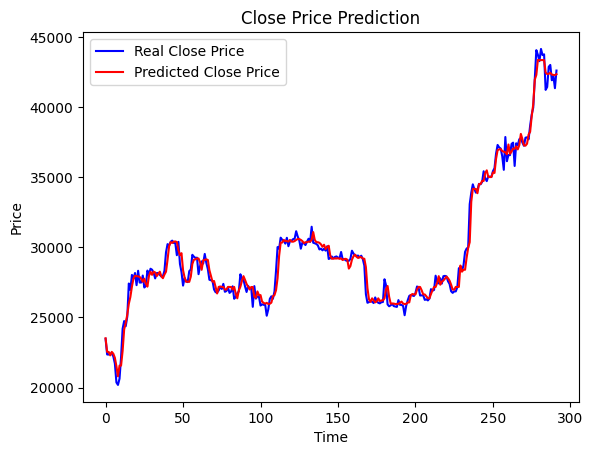

In [16]:
# lineplot train
lineplot(y_train_original, inverse_predictions_train)

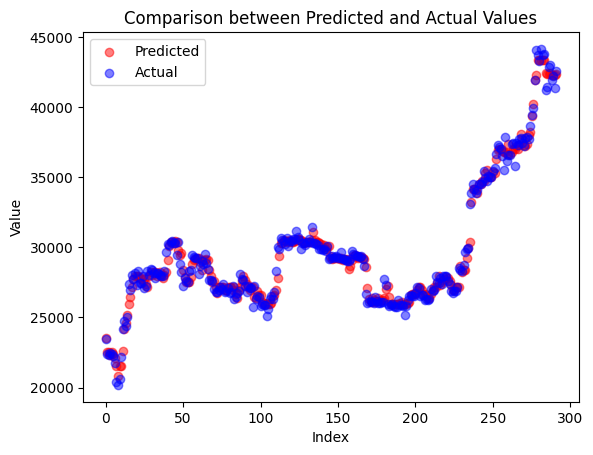

In [17]:
# scatterplot train
scatterplot(y_train_original, inverse_predictions_train)

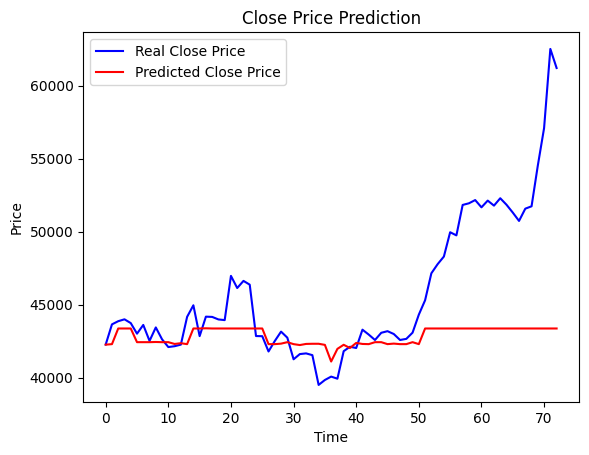

In [18]:
# lineplot test
lineplot(y_test_original, inverse_predictions_test)

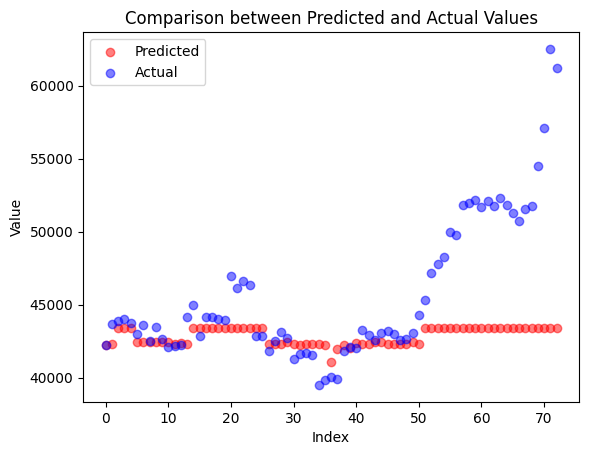

In [19]:
# scatterplot test
scatterplot(y_test_original, inverse_predictions_test)

# SHAP

In [20]:
df.columns

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

In [22]:
feature_names = ['Open', 'High', 'Low']

In [23]:
X_train

array([[0.07002981, 0.08061168, 0.08466681],
       [0.08175457, 0.07736212, 0.0884934 ],
       [0.07772759, 0.07139575, 0.06324821],
       [0.05140581, 0.04672631, 0.06289935],
       [0.05119831, 0.05151491, 0.06554581],
       [0.05315221, 0.05083988, 0.06613724],
       [0.05295146, 0.04953368, 0.05830634],
       [0.04794379, 0.04359647, 0.05088751],
       [0.03621262, 0.03289016, 0.0142414 ],
       [0.0042335 , 0.        , 0.        ],
       [0.        , 0.00969006, 0.01077566],
       [0.01040271, 0.04167041, 0.02007691],
       [0.0465249 , 0.09600364, 0.05602933],
       [0.09486563, 0.14110618, 0.10895223],
       [0.10831736, 0.1118451 , 0.10610731],
       [0.09892344, 0.11069016, 0.11247379],
       [0.11503417, 0.17034416, 0.13033653],
       [0.17159102, 0.16892349, 0.17146871],
       [0.16027931, 0.1853352 , 0.17811055],
       [0.18561763, 0.18733701, 0.18631119],
       [0.17916052, 0.18531228, 0.19112556],
       [0.18838567, 0.19366672, 0.17449618],
       [0.

In [24]:
shap.initjs()

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)
i = 100

shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[30], feature_names=feature_names)

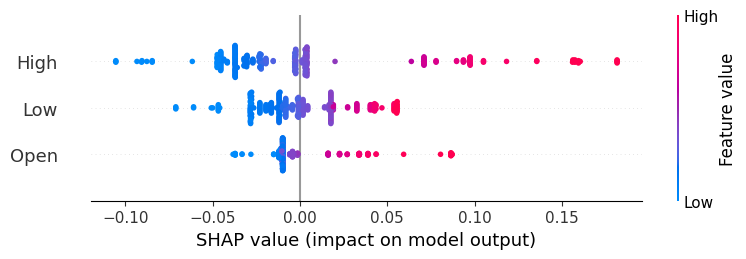

In [25]:
shap.summary_plot(shap_values, features=X_train, feature_names=feature_names)

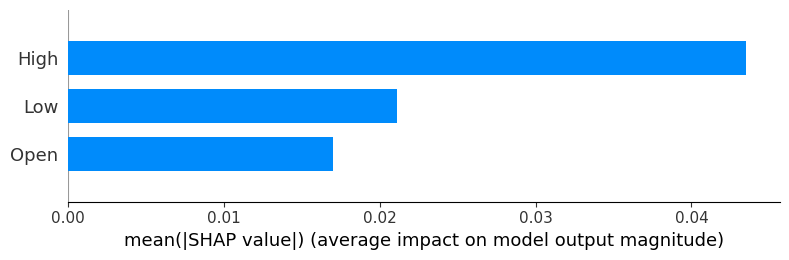

In [26]:
shap.summary_plot(shap_values, features=X_train, feature_names=feature_names, plot_type="bar")